# Exploration and plot generation
This notebook generates many plots based on spells and spells_21_days.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import chain
from collections import Counter
import re
import seaborn as sns  # for easier grouped histogram
import numpy as np

base = Path("/n/scratch/users/b/bef299/polypharmacy_project_fhd8SDd3U50/")


# --- Load data ---
input_suffix = "_sample1M"
output_suffix = "_sample1M_grace15_minspell7_ae_censoring"
opioid_flag = True
if opioid_flag:
    input_suffix = "_opioid" + input_suffix
    output_suffix = "_opioid" + output_suffix
spells = pd.read_parquet(base / f"spells_with_labels{output_suffix}.parquet")
split_spells = pd.read_parquet(base / f"split_spells{output_suffix}.parquet")
# rx_fills = pd.read_parquet(base / f"rx_fills{input_suffix}.parquet")
demographics = pd.read_parquet(base / f"demographics{input_suffix}.parquet")
try:
    drug_changes = pd.read_parquet(base / f"drug_changes{output_suffix}.parquet")
except FileNotFoundError:
    print("Drug changes file not found.")
    drug_changes = pd.DataFrame()

In [2]:
drug_changes['spell_id'].nunique()

140861

📊 Summary of Gaps Between Spells (raw_exit → next entry)
-----------------------------------------------------------------
Version   |   Mean   Median   Std   Min   Max   Count
-----------------------------------------------------------------
15 days   | 198.06    74.00  315.23    16    3678   74,510
-----------------------------------------------------------------


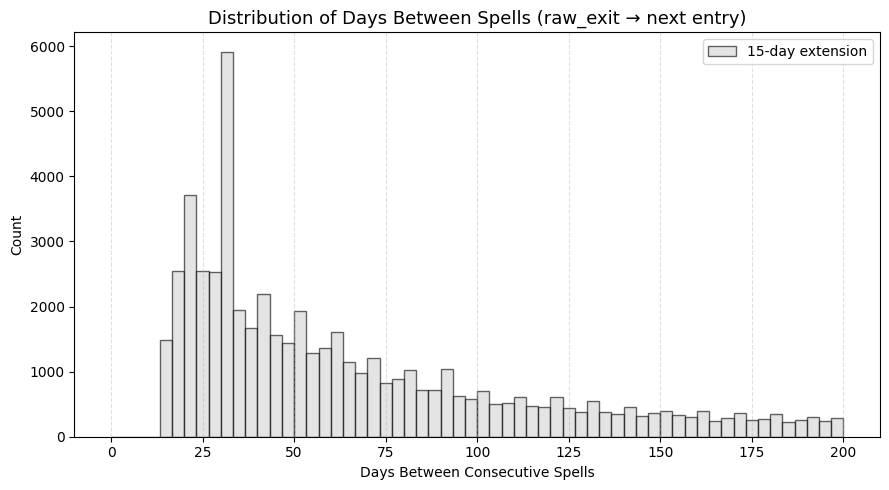

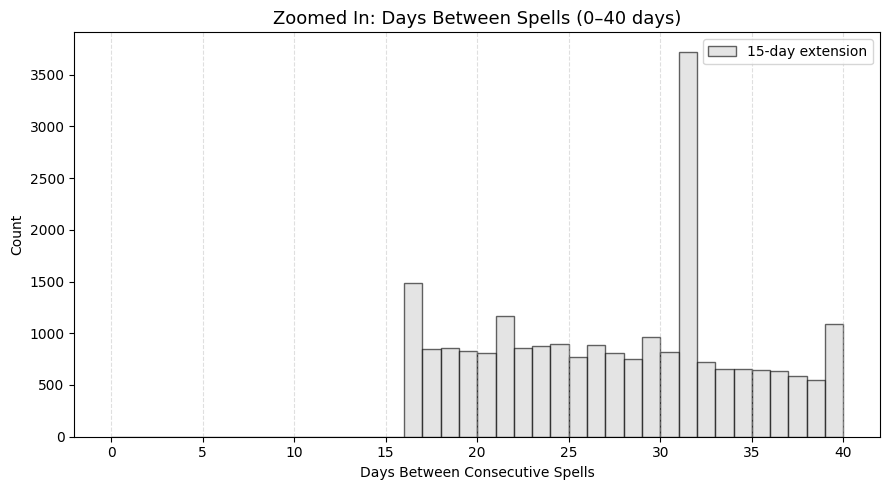

In [3]:
# --- Compare Gap Between Spells (15-day vs 21-day extensions) ---
def compute_gaps(spells_df):
    """Compute gap in days between consecutive spells for each patient."""
    # Ensure datetime types
    date_cols = ["entry_date", "raw_exit_date", "extended_exit_date", "followup_end_date"]
    for col in date_cols:
        if not np.issubdtype(spells_df[col].dtype, np.datetime64):
            spells_df[col] = pd.to_datetime(spells_df[col])
    
    # Sort and compute gap between raw_exit_date of previous spell and next entry_date
    spells_sorted = spells_df.sort_values(["MemberUID", "entry_date"]).copy()
    spells_sorted["days_since_prev_raw_exit"] = (
        spells_sorted["entry_date"] - spells_sorted.groupby("MemberUID")["raw_exit_date"].shift(1)
    ).dt.days
    
    return spells_sorted["days_since_prev_raw_exit"].dropna()

# Compute gaps for both versions
gaps = compute_gaps(spells)

# --- Summary stats ---
print("📊 Summary of Gaps Between Spells (raw_exit → next entry)")
print("-" * 65)
print("Version   |   Mean   Median   Std   Min   Max   Count")
print("-" * 65)
print(f"15 days   | {gaps.mean():6.2f}  {gaps.median():7.2f}  {gaps.std():6.2f}  {gaps.min():4.0f}  {gaps.max():6.0f}  {len(gaps):7,}")
print("-" * 65)

# --- Plot full histogram (0–200 days for clarity) ---
plt.figure(figsize=(9, 5))
plt.hist(gaps, bins=60, range=(0, 200), alpha=0.6, label="15-day extension", color="lightgray", edgecolor="black")
plt.title("Distribution of Days Between Spells (raw_exit → next entry)", fontsize=13)
plt.xlabel("Days Between Consecutive Spells")
plt.ylabel("Count")
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# --- Zoomed-in histogram (0–40 days) ---
plt.figure(figsize=(9, 5))
plt.hist(gaps, bins=40, range=(0, 40), alpha=0.6, label="15-day extension", color="lightgray", edgecolor="black")
plt.title("Zoomed In: Days Between Spells (0–40 days)", fontsize=13)
plt.xlabel("Days Between Consecutive Spells")
plt.ylabel("Count")
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [4]:
# --- 🧮 Spell summary comparison (15 vs 21 day extensions) ---

def summarize_spells(label, df):
    """Get spell summary statistics."""
    total = len(df)
    one_per = len(df.drop_duplicates(subset=["MemberUID"], keep="first"))
    return total, one_per, one_per / total * 100

# Summaries
total, one, pct = summarize_spells("15-day", spells)

print("📊 Spell Summary Comparison")
print("-" * 60)
print(f"{'Config':<20}{'Total Spells':>15}{'1/Patient':>15}{'% of Total':>10}")
print("-" * 60)
print(f"{'15-day extension':<20}{total:>15,}{one:>15,}{pct:>9.2f}%")
print("-" * 60)

# Keep only the one-per-patient spells for further analysis
# spells = spells.drop_duplicates(subset=["MemberUID"], keep="first")


📊 Spell Summary Comparison
------------------------------------------------------------
Config                 Total Spells      1/Patient% of Total
------------------------------------------------------------
15-day extension            132,619         58,109    43.82%
------------------------------------------------------------


In [7]:
ae_freq_df.head()

NameError: name 'ae_freq_df' is not defined


📋 Top Adverse Event Codes and Descriptions
--------------------------------------------------------------------------------
CodeValue  count                                                                                         Description  % of Total
    F1120    791                                              Mental and behavioural disorders due to use of opioids       34.98
  T7840XA    217                                                            Adverse effects not elsewhere classified        9.60
    F1190    216                                              Mental and behavioural disorders due to use of opioids        9.55
    F1920    129  Mental and behavioural disorders due to multiple drug use and use of other psychoactive substances        5.71
  T451X5A    122       Poisoning by adverse effect of and underdosing of drugs medicaments and biological substances        5.40
    F1910    115  Mental and behavioural disorders due to multiple drug use and use of other psychoac

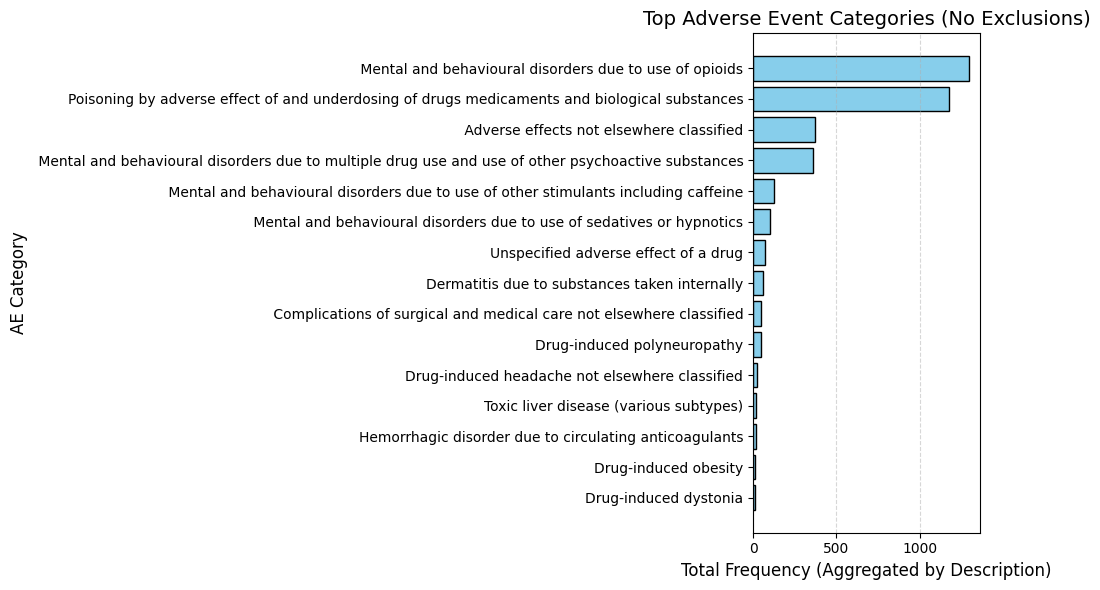


🧮 Aggregated AE Category Counts (for plot)
                                                                                        Description  count
                                             Mental and behavioural disorders due to use of opioids   1296
      Poisoning by adverse effect of and underdosing of drugs medicaments and biological substances   1172
                                                           Adverse effects not elsewhere classified    374
 Mental and behavioural disorders due to multiple drug use and use of other psychoactive substances    362
                 Mental and behavioural disorders due to use of other stimulants including caffeine    126
                              Mental and behavioural disorders due to use of sedatives or hypnotics    104
                                                               Unspecified adverse effect of a drug     74
                                                      Dermatitis due to substances taken internally 

In [5]:
# --- ⚙️ Flatten AE codes across all AE spells ---
# If 'first_ae_code' doesn’t exist, replace it with your AE column (e.g. 'ae_codes')
ae_freq_df = (
    spells["first_ae_code"]
    .value_counts()
    .reset_index()
    .rename(columns={"first_ae_code": "CodeValue"})
)

# --- 📖 Read mapping CSV (with lazy SQL-like patterns) ---
ae_map = pd.read_csv("data/icd10_codes.csv")  # columns: code, description

def map_description(code):
    """Return AE description using SQL-like % wildcards."""
    for _, row in ae_map.iterrows():
        pattern = row["code"].replace("%", "")
        if str(code).startswith(pattern):
            return row["description"]
    return "Unknown AE code"

# Map descriptions
ae_freq_df["Description"] = ae_freq_df["CodeValue"].apply(map_description)

# --- 📊 Summary Table of Top AE Codes ---
top_n = 15
top_ae_df = ae_freq_df.head(top_n).copy()
top_ae_df["% of Total"] = (
    top_ae_df["count"] / top_ae_df["count"].sum() * 100
).round(2)

print("\n📋 Top Adverse Event Codes and Descriptions")
print("-" * 80)
print(top_ae_df.to_string(index=False))
print("-" * 80)
print(f"Showing top {top_n} AE categories out of {len(ae_freq_df):,} total unique codes.\n")

# --- 🔢 Aggregate by Description for visualization ---
agg_by_desc = (
    ae_freq_df.groupby("Description", as_index=False)["count"]
    .sum()
    .sort_values("count", ascending=False)
)

# Take top N descriptions for plotting
top_desc = agg_by_desc.head(top_n)

# --- 🎨 Visualization ---
plt.figure(figsize=(10, 6))
plt.barh(top_desc["Description"], top_desc["count"], color="skyblue", edgecolor="black")
plt.gca().invert_yaxis()  # Highest on top
plt.title("Top Adverse Event Categories (No Exclusions)", fontsize=14)
plt.xlabel("Total Frequency (Aggregated by Description)", fontsize=12)
plt.ylabel("AE Category", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- 🧮 Print small summary of aggregation ---
print("\n🧮 Aggregated AE Category Counts (for plot)")
print(top_desc.to_string(index=False))


📊 AE Positioning Within Spell
--------------------------------------------------
count    3800.000000
mean      119.697895
std       207.278620
min         0.000000
25%        15.000000
50%        41.000000
75%       129.000000
max      1991.000000
Name: days_into_spell, dtype: float64


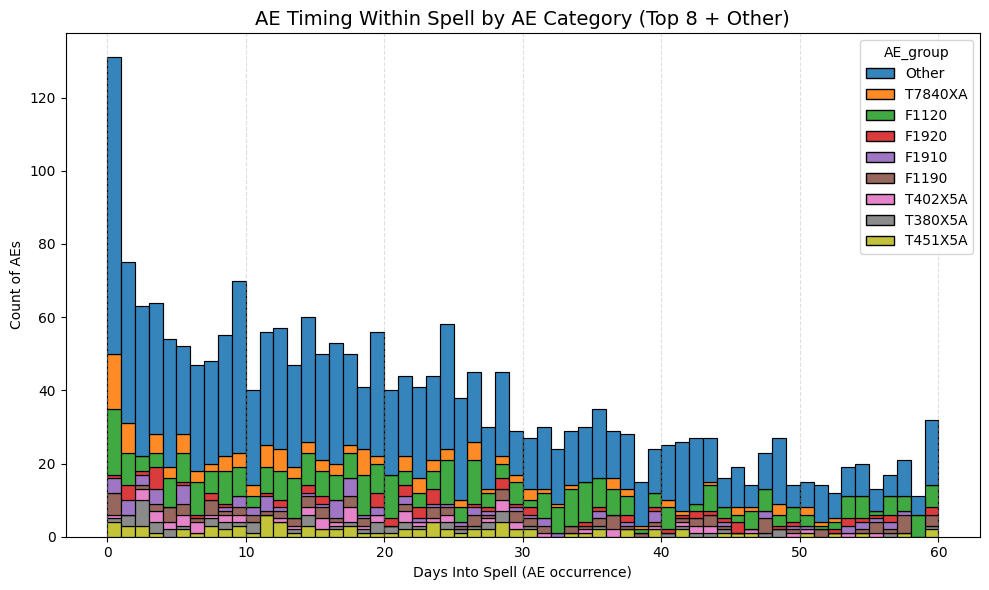

In [6]:
# --- 🧭 AE positioning within spell (days into spell) ---
ae_spells = spells[spells["had_ae"]].copy()

# Ensure datetime
ae_spells["entry_date"] = pd.to_datetime(ae_spells["entry_date"])
ae_spells["first_ae_date"] = pd.to_datetime(ae_spells["first_ae_date"])

# Compute days into spell
ae_spells["days_into_spell"] = (ae_spells["first_ae_date"] - ae_spells["entry_date"]).dt.days

# --- 📊 Summary ---
print("\n📊 AE Positioning Within Spell")
print("-" * 50)
print(ae_spells["days_into_spell"].describe())

# --- 🧩 Identify top AE categories (based on frequency of first_ae_code) ---
top_n = 8
top_codes = (
    ae_spells["first_ae_code"]
    .value_counts()
    .head(top_n)
    .index
    .tolist()
)

# Create a grouped category column
ae_spells["AE_group"] = ae_spells["first_ae_code"].apply(
    lambda x: x if x in top_codes else "Other"
)

# --- 🎨 Plot histogram coloured by AE category ---
plt.figure(figsize=(10, 6))
sns.histplot(
    data=ae_spells,
    x="days_into_spell",
    hue="AE_group",
    bins=60,
    binrange=(0, 60),
    multiple="stack",
    edgecolor="black",
    alpha=0.9
)
plt.title("AE Timing Within Spell by AE Category (Top 8 + Other)", fontsize=14)
plt.xlabel("Days Into Spell (AE occurrence)")
plt.ylabel("Count of AEs")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


📊 AE Positioning Within Spell
--------------------------------------------------
count    3800.000000
mean       18.018158
std        32.722013
min         0.000000
25%         1.000000
50%         8.000000
75%        22.000000
max       470.000000
Name: days_into_spell, dtype: float64


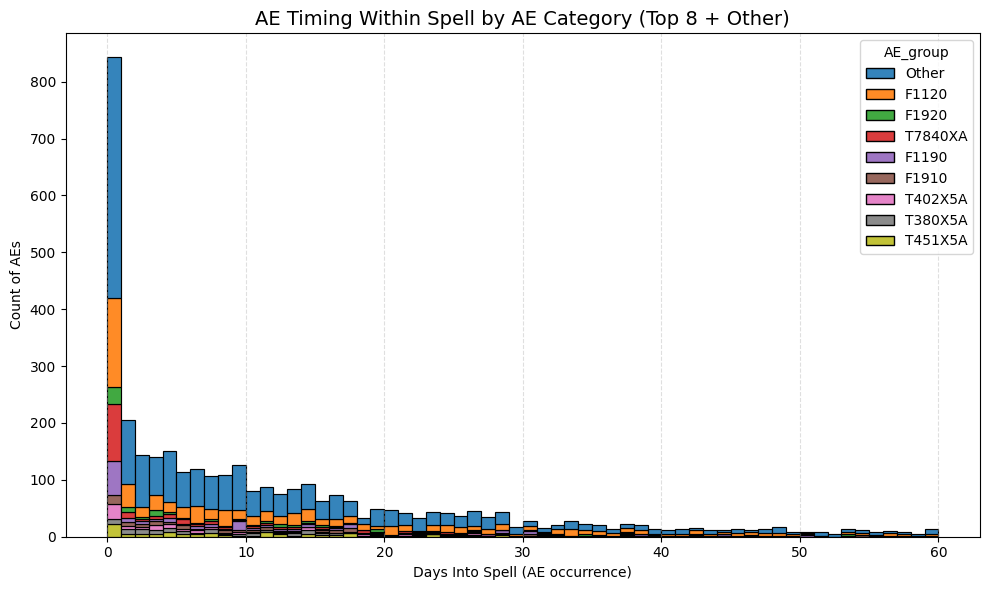

In [7]:
# --- 🧭 AE positioning within split_spells (days into spell) ---
ae_spells_split = split_spells[split_spells["had_ae"]].copy()

# Ensure datetime
ae_spells_split["entry_date"] = pd.to_datetime(ae_spells_split["entry_date"])
ae_spells_split["first_ae_date"] = pd.to_datetime(ae_spells_split["first_ae_date"])

# Compute days into spell
ae_spells_split["days_into_spell"] = (ae_spells_split["first_ae_date"] - ae_spells_split["entry_date"]).dt.days

# --- 📊 Summary ---
print("\n📊 AE Positioning Within Spell")
print("-" * 50)
print(ae_spells_split["days_into_spell"].describe())

# --- 🧩 Identify top AE categories (based on frequency of first_ae_code) ---
top_n = 8
top_codes = (
    ae_spells_split["first_ae_code"]
    .value_counts()
    .head(top_n)
    .index
    .tolist()
)

# Create a grouped category column
ae_spells_split["AE_group"] = ae_spells_split["first_ae_code"].apply(
    lambda x: x if x in top_codes else "Other"
)

# --- 🎨 Plot histogram coloured by AE category ---
plt.figure(figsize=(10, 6))
sns.histplot(
    data=ae_spells_split,
    x="days_into_spell",
    hue="AE_group",
    bins=60,
    binrange=(0, 60),
    multiple="stack",
    edgecolor="black",
    alpha=0.9
)
plt.title("AE Timing Within Spell by AE Category (Top 8 + Other)", fontsize=14)
plt.xlabel("Days Into Spell (AE occurrence)")
plt.ylabel("Count of AEs")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

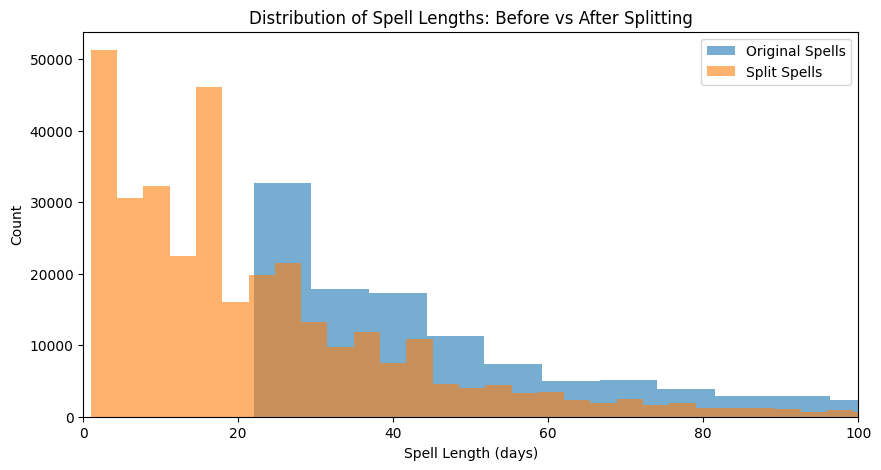

Original Spells Summary:
count    132619.000000
mean         83.961966
std         138.273629
min          22.000000
25%          30.000000
50%          44.000000
75%          79.000000
max        3743.000000
Name: spell_length_days, dtype: float64

Split Spells Summary:
count    338997.000000
mean         25.438827
std          32.226773
min           1.000000
25%           8.000000
50%          15.000000
75%          32.000000
max        1697.000000
Name: spell_length_days, dtype: float64


In [4]:
# --- 1. Distribution of spell lengths before and after splitting ---

import matplotlib.pyplot as plt

# Original spell lengths
spell_lengths = spells['spell_length_days']

# Split spell lengths
split_spell_lengths = split_spells['spell_length_days']

# Plot
plt.figure(figsize=(10,5))
plt.hist(spell_lengths, bins=500, alpha=0.6, label='Original Spells')
plt.hist(split_spell_lengths, bins=500, alpha=0.6, label='Split Spells')
plt.xlabel('Spell Length (days)')
plt.ylabel('Count')
plt.xlim(0, 100)  # Set x-axis limits
plt.title('Distribution of Spell Lengths: Before vs After Splitting')
plt.legend()
plt.show()

# Summary statistics
print("Original Spells Summary:")
print(spell_lengths.describe())
print("\nSplit Spells Summary:")
print(split_spell_lengths.describe())


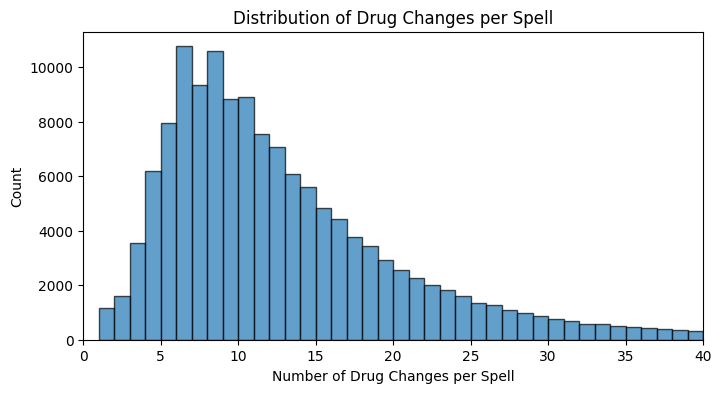

count    140861.000000
mean         14.307133
std          14.838054
min           1.000000
25%           7.000000
50%          11.000000
75%          17.000000
max         432.000000
dtype: float64


In [7]:
# --- 2. Distribution of number of drug changes per spell ---

# Count drug changes per spell_id
drug_changes_per_spell = drug_changes.groupby('spell_id').size()

# Plot
plt.figure(figsize=(8,4))
plt.hist(drug_changes_per_spell, bins=range(1, drug_changes_per_spell.max()+2), edgecolor='black', alpha=0.7)
plt.xlabel('Number of Drug Changes per Spell')
plt.ylabel('Count')
plt.xlim(0, 40)  # Focus on 0-20 range for clarity
plt.title('Distribution of Drug Changes per Spell')
plt.show()

# Summary statistics
print(drug_changes_per_spell.describe())


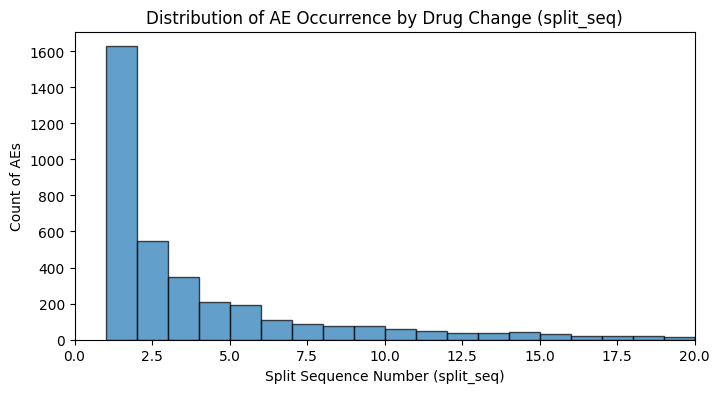

split_seq
1     1628
2      545
3      349
4      211
5      191
      ... 
73       1
74       1
78       1
88       1
95       1
Name: count, Length: 67, dtype: int64


In [10]:
# --- 3. At which drug change does AE occur (split_seq) ---

# Filter split spells that had an AE
ae_spells = split_spells[split_spells['had_ae'] == True]

# Distribution of AE occurrence by split_seq
plt.figure(figsize=(8,4))
plt.hist(ae_spells['split_seq'], bins=range(1, ae_spells['split_seq'].max()+2), edgecolor='black', alpha=0.7)
plt.xlabel('Split Sequence Number (split_seq)')
plt.ylabel('Count of AEs')
plt.xlim(0, 20)
plt.title('Distribution of AE Occurrence by Drug Change (split_seq)')
plt.show()

# Summary
print(ae_spells['split_seq'].value_counts().sort_index())


In [ ]:
# Explore the present drug combos (need some code to derive the drug combos from the drug_changes and the split_spells, basically look at the start date and check which drugs are active at that time)

In [ ]:
# Code to take the letter + two digits of ICD-10 codes for comorbidity grouping. Show how many comorbidities per patient.

In [17]:
# --- 👥 Demographics Comparison: AE vs Non-AE ---

# Define AE and Non-AE members
ae_members = ae_spells["MemberUID"].unique()
non_ae_members = spells_21_days.loc[~spells_21_days["MemberUID"].isin(ae_members), "MemberUID"].unique()

ae_demo = demographics[demographics["MemberUID"].isin(ae_members)].copy()
non_ae_demo = demographics[demographics["MemberUID"].isin(non_ae_members)].copy()

print(f"\n📊 Demographics Summary")
print("-" * 60)
print(f"AE patients: {len(ae_demo):,}")
print(f"Non-AE patients: {len(non_ae_demo):,}")
print("-" * 60)

# --- Gender distribution ---
gender_ae = ae_demo["gendercode"].value_counts(normalize=True).rename("AE (%)") * 100
gender_non = non_ae_demo["gendercode"].value_counts(normalize=True).rename("Non-AE (%)") * 100
gender_table = pd.concat([gender_ae, gender_non], axis=1).fillna(0).round(2)

# --- Race / Ethnicity distribution ---
race_ae = ae_demo["raceethnicitytypecode"].value_counts(normalize=True).rename("AE (%)") * 100
race_non = non_ae_demo["raceethnicitytypecode"].value_counts(normalize=True).rename("Non-AE (%)") * 100
race_table = pd.concat([race_ae, race_non], axis=1).fillna(0).round(2)

# --- State distribution (Top 10 AE states) ---
state_ae = ae_demo["statecode"].value_counts(normalize=True).rename("AE (%)") * 100
state_non = non_ae_demo["statecode"].value_counts(normalize=True).rename("Non-AE (%)") * 100
# Restrict to top 10 AE states for clarity
top_states = state_ae.head(10).index
state_table = pd.concat([state_ae.loc[top_states], state_non.loc[top_states]], axis=1).fillna(0).round(2)

# --- Display results ---
print("\n🧍 Gender Distribution (% of group):")
print(gender_table.to_string())

print("\n🌎 Race / Ethnicity Distribution (% of group):")
print(race_table.to_string())

print("\n📍 Top 10 States (by AE frequency, % of group):")
print(state_table.to_string())



📊 Demographics Summary
------------------------------------------------------------
AE patients: 10,616
Non-AE patients: 45,802
------------------------------------------------------------

🧍 Gender Distribution (% of group):
            AE (%)  Non-AE (%)
gendercode                    
F            65.11       60.37
M            34.89       39.63

🌎 Race / Ethnicity Distribution (% of group):
                       AE (%)  Non-AE (%)
raceethnicitytypecode                    
09                      45.25       50.91
01                      33.72       26.55
02                       9.83        9.54
11                       5.11        5.77
06                       4.81        5.84
04                       1.26        1.40

📍 Top 10 States (by AE frequency, % of group):
           AE (%)  Non-AE (%)
statecode                    
CA          11.19       12.00
TX           7.93        6.97
MI           6.46        5.12
OH           6.32        6.52
NY           5.64        7.65
IL      